In [1]:
#####################
# IMPORT LIBS
#####################

import lightgbm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import wandb
import datetime
import os
import random
import joblib
import shutil

sns.set()

from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from scoring import local_scorer
import scipy

from lightgbm import LGBMClassifier, LGBMRegressor


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH 

TARGET_COLUMNS = ['sale_flg', 'sale_amount', 'contacts']
FIXED_SEEDS = [948, 534, 432, 597, 103, 21, 2242, 17, 20, 29]

RANDOM_SEED = 4444
USE_WANDB = False
CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)

In [2]:
###############
# Config
###############

n_seed = 10
n_fold = 3
make_submission = True

In [3]:
if USE_WANDB:
    wandb.login()
    run = wandb.init(project="idao-2021-finals", name = f'{CURRENT_TIME}') # todo add config here

## Data prep

In [4]:
def get_feature_total(df, col_name):
    return data['client_id'].map(df.groupby(['client_id', col_name]).size().index.get_level_values('client_id').value_counts()).fillna(0)


def get_feature_most_common(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: scipy.stats.mode(x)[0][0])).fillna(fill_na_value)


def get_feature_max(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].max()).fillna(fill_na_value)


def get_feature_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].min()).fillna(fill_na_value)


def get_feature_mean(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].mean()).fillna(fill_na_value)


def get_feature_std(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].std()).fillna(fill_na_value)


def get_feature_max_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: x.max() - x.min())).fillna(fill_na_value)


def get_feature_timedelta(df, col_name):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: (x.max() - x.min()).days)).fillna(-1)


def get_feature_diff(df, col_name1, col_name2, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name1].sum() - df.groupby('client_id')[col_name2].sum()).fillna(fill_na_value)


def get_feature_rate(df, col_name1, col_name2, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name1].sum() / (df.groupby('client_id')[col_name2].sum() + 1e-12)).fillna(fill_na_value)


def create_features_transactions(data):
    
    transactions = pd.read_csv(INPUT_PATH / 'trxn.csv')
    dict_merchant_category_code = pd.read_csv(INPUT_PATH / 'dict_mcc.csv')
    
    transactions['mcc_cd'] = transactions['mcc_cd'].fillna(-2)
    transactions['txn_city'] = transactions['txn_city'].fillna('<UNK>')
    transactions['tsp_name'] = transactions['tsp_name'].fillna('<UNK>')
    transactions['txn_comment_2'] = transactions['txn_comment_2'].fillna('<UNK>')

    transactions = transactions.merge(dict_merchant_category_code, on='mcc_cd', how='left')
    del dict_merchant_category_code
    transactions['brs_mcc_group'] = transactions['brs_mcc_group'].fillna('<UNK>')
    transactions['brs_mcc_subgroup'] = transactions['brs_mcc_subgroup'].fillna('<UNK>')
    
    data['total_transactions'] = data['client_id'].map(transactions.groupby('client_id').size()).fillna(0)
#     data['total_transactions_cards'] = get_feature_total(transactions, 'card_id')

#     data['total_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].sum()).fillna(0) # add monthly, daily, etc
    data['mean_transaction_amt'] = get_feature_mean(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    data['std_transaction_amount'] = get_feature_std(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    
    data['total_transactions_mcc_cd'] = get_feature_total(transactions, 'mcc_cd')
    data['total_transactions_share_mcc_cd'] = (data['total_transactions_mcc_cd'] / data['total_transactions']).fillna(0)
#     data['most_common_transactions_mcc_cd'] = get_feature_most_common(transactions, 'mcc_cd', -1)
    
    data['total_transactions_merchant_cd'] = get_feature_total(transactions, 'merchant_cd')
    data['total_share_transactions_merchant_cd'] = (data['total_transactions_merchant_cd'] / data['total_transactions']).fillna(0)
#     data['most_common_transactions_merchant_cd'] = get_feature_most_common(transactions, 'merchant_cd', -1)
    
    data['total_transactions_txn_city'] = get_feature_total(transactions, 'txn_city')
    data['total_share_transactions_txn_city'] = (data['total_transactions_txn_city'] / data['total_transactions']).fillna(0)
    data['most_common_transactions_txn_city'] = get_feature_most_common(transactions, 'txn_city', '<unknown>')
    
    data['total_transactions_tsp_name'] = get_feature_total(transactions, 'tsp_name')
    data['total_share_transactions_tsp_name'] = (data['total_transactions_tsp_name'] / data['total_transactions']).fillna(0)
    data['most_common_transactions_tsp_name'] = get_feature_most_common(transactions, 'tsp_name', '<unknown>')
    
#     data['total_transactions_txn_comment_1'] = get_feature_total(transactions, 'txn_comment_1')
#     data['most_common_transactions_txn_comment_1'] = get_feature_most_common(transactions, 'txn_comment_1', '<unknown>')
    
#     data['total_transactions_txn_comment_2'] = get_feature_total(transactions, 'txn_comment_2')
#     data['most_common_transactions_txn_comment_2'] = get_feature_most_common(transactions, 'txn_comment_2', '<unknown>')
    
#     data['total_transactions_brs_mcc_group'] = get_feature_total(transactions, 'brs_mcc_group')
#     data['most_common_transactions_brs_mcc_group'] = get_feature_most_common(transactions, 'brs_mcc_group', '<unknown>')
    
#     data['total_transactions_brs_mcc_subgroup'] = get_feature_total(transactions, 'brs_mcc_subgroup')
#     data['most_common_transactions_brs_mcc_subgroup'] = get_feature_most_common(transactions, 'brs_mcc_subgroup', '<unknown>')
    
    del transactions

    return data


def create_features_aum(data):
    
    assets_under_management = pd.read_csv(INPUT_PATH / 'aum.csv')
    
    data['total_aum'] = data['client_id'].map(assets_under_management.groupby('client_id').size()).fillna(0)
    
#     data['total_aum_product_code'] = get_feature_total(assets_under_management, 'product_code')
#     data['most_common_aum_product_code'] = get_feature_most_common(assets_under_management, 'product_code', '<unknown>').value_counts()
    
    data['mean_aum_balance_rur_amt'] = get_feature_mean(assets_under_management, 'balance_rur_amt', -1)
    data['std_aum_balance_rur_amt'] = get_feature_std(assets_under_management, 'balance_rur_amt', -1)
    data['max_min_aum_balance_rur_amt'] = get_feature_max_min(assets_under_management, 'balance_rur_amt', -1)
    
    del assets_under_management
    
    return data


def create_features_balance(data):
    
    balance = pd.read_csv(INPUT_PATH / 'balance.csv')
    
    balance['crncy_cd'] = balance['crncy_cd'].fillna(-2)
    balance['prod_cat_name'] = balance['prod_cat_name'].fillna('<UNK>')
    balance['prod_group_name'] = balance['prod_group_name'].fillna('<UNK>')
    
    data['total_balance'] = data['client_id'].map(balance.groupby('client_id').size()).fillna(0)
    
#     data['total_balance_crncy_cd'] = get_feature_total(balance, 'crncy_cd')
#     data['most_common_balance_crncy_cd'] = get_feature_most_common(balance, 'crncy_cd', -1)
    
#     data['total_balance_eop_bal_sum_rur'] = get_feature_total(balance, 'eop_bal_sum_rur')
    data['total_share_balance_eop_bal_sum_rur'] = (get_feature_total(balance, 'eop_bal_sum_rur') / data['total_balance']).fillna(0)
    data['mean_balance_eop_bal_sum_rur'] = get_feature_mean(balance, 'eop_bal_sum_rur', -9999)
    data['std_balance_eop_bal_sum_rur'] = get_feature_std(balance, 'eop_bal_sum_rur', -9999)
    
    data['total_balance_min_bal_sum_rur'] = get_feature_total(balance, 'min_bal_sum_rur')
    data['total_share_balance_min_bal_sum_rur'] = (data['total_balance_min_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_balance_min_bal_sum_rur'] = get_feature_mean(balance, 'min_bal_sum_rur', -9999)
    data['std_balance_min_bal_sum_rur'] = get_feature_std(balance, 'min_bal_sum_rur', -9999)
    
    data['total_balance_max_bal_sum_rur'] = get_feature_total(balance, 'max_bal_sum_rur')
    data['total_share_balance_max_bal_sum_rur'] = (data['total_balance_max_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_balance_max_bal_sum_rur'] = get_feature_mean(balance, 'max_bal_sum_rur', -9999)
    data['std_balance_max_bal_sum_rur'] = get_feature_std(balance, 'max_bal_sum_rur', -9999)
    
    data['total_balance_avg_bal_sum_rur'] = get_feature_total(balance, 'avg_bal_sum_rur')
    data['total_share_balance_avg_bal_sum_rur'] = (data['total_balance_avg_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_balance_avg_bal_sum_rur'] = get_feature_mean(balance, 'avg_bal_sum_rur', -9999)
#     data['std_balance_avg_bal_sum_rur'] = get_feature_std(balance, 'avg_bal_sum_rur', -9999)
    data['max_min_balance_avg_bal_sum_rur'] = get_feature_max_min(balance, 'avg_bal_sum_rur', -9999)
    
#     data['total_balance_prod_cat_name'] = get_feature_total(balance, 'prod_cat_name')
#     data['most_common_balance_prod_cat_name'] = get_feature_most_common(balance, 'prod_cat_name', '<unknown>')
    
    data['total_balance_prod_group_name'] = get_feature_total(balance, 'prod_group_name')
#     data['most_common_balance_prod_group_name'] = get_feature_most_common(balance, 'prod_group_name', '<unknown>')
    
    del balance

    return data


def create_features_client(data):
    
    client = pd.read_csv(INPUT_PATH / 'client.csv')
    
    client = client.rename(columns={
        'gender': 'client_gender',
        'age': 'client_age',
        'region': 'client_region',
        'city': 'client_city',
        'citizenship': 'client_citizenship',
        'education': 'client_education',
        'job_type': 'client_job_type'
    })
    
    data = data.merge(client, on='client_id')
#     data['match_client_region-region_cd'] = (data['client_region'] == data['region_cd']).astype(int)
    data = data.drop(['client_citizenship', 'client_job_type', 'client_gender'], axis=1)
    
    del client
    
    return data


def create_features_campaigns(data):

    campaigns = pd.read_csv(INPUT_PATH / 'com.csv')
    
    campaigns['prod'] = campaigns['prod'].fillna('<UNK>')
    
    data['total_campaigns'] = data['client_id'].map(campaigns.groupby('client_id').size()).fillna(0)
    
#     data['total_campaigns_agr_flg'] = get_feature_total(campaigns, 'agr_flg')
    data['mean_campaigns_agr_flg'] = get_feature_mean(campaigns, 'agr_flg', -1)
    
#     data['total_campaigns_otkaz'] = get_feature_total(campaigns, 'otkaz')
    data['mean_campaigns_otkaz'] = get_feature_mean(campaigns, 'otkaz', -1)
    
#     data['total_campaigns_dumaet'] = get_feature_total(campaigns, 'dumaet')
    data['mean_campaigns_dumaet'] = get_feature_mean(campaigns, 'dumaet', -1)
    
#     data['total_campaigns_ring_up_flg'] = get_feature_total(campaigns, 'ring_up_flg')
#     data['most_common_campaigns_ring_up_flg'] = get_feature_most_common(campaigns, 'ring_up_flg', -1)
    
#     data['total_campaigns_count_comm'] = get_feature_total(campaigns, 'count_comm')
#     data['most_common_campaigns_count_comm'] = get_feature_most_common(campaigns, 'count_comm', -1)
    
#     data['total_campaigns_channel'] = get_feature_total(campaigns, 'channel')
#     data['most_common_campaigns_channel'] = get_feature_most_common(campaigns, 'channel', '<unknown>')
    
#     data['total_campaigns_prod'] = get_feature_total(campaigns, 'prod')
    data['most_common_campaigns_prod'] = get_feature_most_common(campaigns, 'prod', '<unknown>')
    
#     data['diff_campaigns_otkaz-agr_flg'] = get_feature_diff(campaigns, 'otkaz', 'agr_flg', -999)
    
    data['rate_campaigns_otkaz-count_comm'] = get_feature_rate(campaigns, 'otkaz', 'count_comm', -999)
    data['rate_campaigns_agr_flg-count_comm'] = get_feature_rate(campaigns, 'agr_flg', 'count_comm', -999)
    data['rate_campaigns_not_ring_up_flg-count_comm'] = get_feature_rate(campaigns, 'not_ring_up_flg', 'count_comm', -999)
    data['rate_campaigns_ring_up_flg-count_comm'] = get_feature_rate(campaigns, 'ring_up_flg', 'count_comm', -999)
    
    del campaigns
    
    return data


def create_features_deals(data):
    
    deals = pd.read_csv(INPUT_PATH / 'deals.csv')
    
    deals['crncy_cd'] = deals['crncy_cd'].fillna(-2)
    deals['agrmnt_rate_active'] = deals['agrmnt_rate_active'].fillna(-2)
    deals['agrmnt_rate_passive'] = deals['agrmnt_rate_passive'].fillna(-2)
    deals['agrmnt_sum_rur'] = deals['agrmnt_sum_rur'].fillna(-2)
    deals['prod_type_name'] = deals['prod_type_name'].fillna('<UNK>')
    deals['argmnt_close_start_days'] = (pd.to_datetime(deals['agrmnt_close_dt']) - pd.to_datetime(deals['agrmnt_start_dt'])).dt.days.fillna(-2)
    
    data['total_deals'] = data['client_id'].map(deals.groupby('client_id').size()).fillna(0)
    
#     data['total_deals_crncy_cd'] = get_feature_total(deals, 'crncy_cd')
#     data['most_common_deals_crncy_cd'] = get_feature_most_common(deals, 'crncy_cd', -1)
    
    data['total_deals_agrmnt_rate_active'] = get_feature_total(deals, 'agrmnt_rate_active')
    data['max_deals_agrmnt_rate_active'] = get_feature_max(deals, 'agrmnt_rate_active', -1)
    
#     data['total_deals_agrmnt_rate_passive'] = get_feature_total(deals, 'agrmnt_rate_passive')
    data['max_deals_agrmnt_rate_passive'] = get_feature_max(deals, 'agrmnt_rate_passive', -1)
    
    data['total_deals_agrmnt_sum_rur'] = get_feature_total(deals, 'agrmnt_sum_rur')
    data['mean_deals_agrmnt_sum_rur'] = get_feature_mean(deals, 'agrmnt_sum_rur', -1)
    data['std_deals_agrmnt_sum_rur'] = get_feature_std(deals, 'agrmnt_sum_rur', -1)
    
    data['total_deals_prod_type_name'] = get_feature_total(deals, 'prod_type_name')
    data['most_common_deals_prod_type_name'] = get_feature_most_common(deals, 'prod_type_name', '<unknown>')
    
    data['total_deals_argmnt_close_start_days'] = get_feature_total(deals, 'argmnt_close_start_days')
    data['max_deals_argmnt_close_start_days'] = get_feature_max(deals, 'argmnt_close_start_days', -1)
#     data['min_deals_argmnt_close_start_days'] = get_feature_min(deals, 'argmnt_close_start_days', -1)
    data['mean_deals_argmnt_close_start_days'] = get_feature_mean(deals, 'argmnt_close_start_days', -1)
    data['std_deals_argmnt_close_start_days'] = get_feature_std(deals, 'argmnt_close_start_days', -1)
    
    del deals
    
    return data


def create_features_payments(data):
    
    payments = pd.read_csv(INPUT_PATH / 'payments.csv')
    
    payments['day_dt'] = pd.to_datetime(payments['day_dt'])
    
    data['total_payments'] = data['client_id'].map(payments.groupby('client_id').size()).fillna(0)
    
    data['mean_payments_sum_rur'] = get_feature_mean(payments, 'sum_rur', -1)
    data['std_payments_sum_rur'] = get_feature_std(payments, 'sum_rur', -1)
    data['min_payments_sum_rur'] = get_feature_min(payments, 'sum_rur', -1)
    data['max_payments_sum_rur'] = get_feature_max(payments, 'sum_rur', -1)
    
#     data['total_payments_pmnts_name'] = get_feature_total(payments, 'pmnts_name')
#     data['most_common_payments_pmnts_name'] = get_feature_most_common(payments, 'pmnts_name', '<unknown>')
    
    # payments 
#     data['last_known_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].iloc[0])).fillna(-1)
#     data['total_recieved_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].sum())).fillna(-1)
    
    data['timedelta_payments_day_dt'] = get_feature_timedelta(payments, 'day_dt')
    
    del payments
    
    return data


def create_features_appl(data):
    
    appl = pd.read_csv(INPUT_PATH / 'appl.csv')
    
    appl['appl_stts_name_dc'] = appl['appl_stts_name_dc'].fillna('<UNK>')
    appl['appl_sale_channel_name'] = appl['appl_sale_channel_name'].fillna('<UNK>')
    appl['month_end_dt'] = pd.to_datetime(appl['month_end_dt'])
    
    data['total_appl'] = data['client_id'].map(appl.groupby('client_id').size()).fillna(0)
    
#     data['total_appl_prod_group_name'] = get_feature_total(appl, 'appl_prod_group_name')
#     data['most_common_appl_prod_group_name'] = get_feature_most_common(appl, 'appl_prod_group_name', '<unknown>')
    
    data['total_appl_prod_type_name'] = get_feature_total(appl, 'appl_prod_type_name')
    data['most_common_appl_prod_type_name'] = get_feature_most_common(appl, 'appl_prod_type_name', '<unknown>')
    
#     data['total_appl_stts_name_dc'] = get_feature_total(appl, 'appl_stts_name_dc')
#     data['most_common_appl_stts_name_dc'] = get_feature_most_common(appl, 'appl_stts_name_dc', '<unknown>')
    
#     data['total_appl_sale_channel_name'] = get_feature_total(appl, 'appl_sale_channel_name')
#     data['most_common_appl_sale_channel_name'] = get_feature_most_common(appl, 'appl_sale_channel_name', '<unknown>')
    
    data['timedelta_appl_month_end_dt'] = get_feature_timedelta(appl, 'month_end_dt')
    
    del appl
    
    return data


def create_features_funnel(data):
    
    return data

In [5]:
%%time
# create features

funnel = pd.read_csv(INPUT_PATH / 'funnel.csv')

data = funnel.copy()

del funnel

data = create_features_transactions(data)
data = create_features_aum(data)
data = create_features_balance(data)
data = create_features_client(data)
data = create_features_campaigns(data)
data = create_features_deals(data)
data = create_features_payments(data)
data = create_features_appl(data)
data = create_features_funnel(data)

/opt/conda/lib/python3.7/site-packages/IPython/core/magic.py:187: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 37.7 s, sys: 1.22 s, total: 38.9 s
Wall time: 38.6 s


In [6]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [7]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [8]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [9]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

## Hyperparameter tuning

In [10]:
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

In [257]:
# %%time
# import lightgbm as lgb
# def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
#     # prepare data
#     train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
#     # parameters
#     def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
#         params = {'application':'binary', 'metric':'auc'}
#         params['learning_rate'] = max(min(learning_rate, 1), 0)
#         params["num_leaves"] = int(round(num_leaves))
#         params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#         params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
#         params['max_depth'] = int(round(max_depth))
#         params['max_bin'] = int(round(max_depth))
#         params['min_data_in_leaf'] = int(round(min_data_in_leaf))
#         params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
#         params['subsample'] = max(min(subsample, 1), 0)
#         params['n_estimators'] = n_estimators        
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =False, metrics=['auc'])
#         return max(cv_result['auc-mean'])
     
#     lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
#                                             'num_leaves': (24, 80),
#                                             'feature_fraction': (0.1, 0.9),
#                                             'bagging_fraction': (0.8, 1),
#                                             'max_depth': (5, 30),
#                                             'max_bin':(20,90),
#                                             'min_data_in_leaf': (20, 80),
#                                             'min_sum_hessian_in_leaf':(0,100),
#                                            'subsample': (0.01, 1.0)}, random_state=200)

    
#     #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
#     #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
#     lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
#     model_auc=[]
#     for model in range(len( lgbBO.res)):
#         model_auc.append(lgbBO.res[model]['target'])
    
#     # return best parameters
#     return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

# opt_params = bayes_parameter_opt_lgb(X, Y, init_round=10, opt_round=30, n_folds=3, random_seed=6,n_estimators=100)

In [197]:
opt_params

(0.938570844729479,
 {'bagging_fraction': 0.9365892138337456,
  'feature_fraction': 0.4612190856657764,
  'learning_rate': 0.05015112291766955,
  'max_bin': 80.97261071729622,
  'max_depth': 24.027491028553776,
  'min_data_in_leaf': 63.77942902042988,
  'min_sum_hessian_in_leaf': 27.789622127133008,
  'num_leaves': 25.657235250894324,
  'subsample': 0.37005506694846135})

In [226]:
opt_params = (0, {'bagging_fraction': 0.8544894153597918,
 'feature_fraction': 0.511319319449425,
 'learning_rate': 0.01,
 'max_bin': 78,
 'max_depth': 29,
 'min_data_in_leaf': 67,
 'min_sum_hessian_in_leaf': 32.8086025188172,
 'num_leaves': 31,
 'subsample': 0.01,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': True,
 'n_jobs': -1,
 'random_state': 29,
 'n_estimators': 1000})

In [227]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 0.8544894153597918,
 'feature_fraction': 0.511319319449425,
 'learning_rate': 0.01,
 'max_bin': 78,
 'max_depth': 29,
 'min_data_in_leaf': 67,
 'min_sum_hessian_in_leaf': 32.8086025188172,
 'num_leaves': 31,
 'subsample': 0.01,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False,
 'n_jobs': -1,
 'random_state': 29,
 'n_estimators': 1000}

In [250]:
opt_params

{'bagging_fraction': 0.8544894153597918,
 'feature_fraction': 0.511319319449425,
 'learning_rate': 0.01,
 'max_bin': 78,
 'max_depth': 29,
 'min_data_in_leaf': 67,
 'min_sum_hessian_in_leaf': 32.8086025188172,
 'num_leaves': 31,
 'subsample': 0.01,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False,
 'n_jobs': -1,
 'random_state': 29,
 'n_estimators': 1000}

## Train

In [228]:
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [229]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [251]:
import lightgbm as lgb
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
          'n_jobs': -1,
          'random_state': seed
          }
    
#     opt_params['n_jobs'] = -1
#     opt_params['random_state'] = seed
#     opt_params['n_estimators'] = 1000
#     opt_params['boost_from_average'] = True
    
    
    
    model = lgb.LGBMClassifier(**params) # define model here
    #model = LGBMRegressor(**params)
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [252]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
models_fe_split = []
models_fe_gain = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')
        models_fe_split.append(model.booster_.feature_importance(importance_type='split'))
        models_fe_gain.append(model.booster_.feature_importance(importance_type='gain'))

        prediction = model.predict_proba(X_val)[:, 1]
        #prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

Seed: 948, 1/10
# Fold: 1/3 (seed: 1/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 1/10)
predict on oof...  done.
# Fold: 3/3 (seed: 1/10)
predict on oof...  done.
Seed: 534, 2/10
# Fold: 1/3 (seed: 2/10)
predict on oof...  done.
# Fold: 2/3 (seed: 2/10)
predict on oof...  done.
# Fold: 3/3 (seed: 2/10)
predict on oof...  done.
Seed: 432, 3/10
# Fold: 1/3 (seed: 3/10)
predict on oof...  done.
# Fold: 2/3 (seed: 3/10)
predict on oof...  done.
# Fold: 3/3 (seed: 3/10)
predict on oof...  done.
Seed: 597, 4/10
# Fold: 1/3 (seed: 4/10)
predict on oof...  done.
# Fold: 2/3 (seed: 4/10)
predict on oof...  done.
# Fold: 3/3 (seed: 4/10)
predict on oof...  done.
Seed: 103, 5/10
# Fold: 1/3 (seed: 5/10)
predict on oof...  done.
# Fold: 2/3 (seed: 5/10)
predict on oof...  done.
# Fold: 3/3 (seed: 5/10)
predict on oof...  done.
Seed: 21, 6/10
# Fold: 1/3 (seed: 6/10)
predict on oof...  done.
# Fold: 2/3 (seed: 6/10)
predict on oof...  done.
# Fold: 3/3 (seed: 6/10)
predict on oof...  done.
Seed: 2242, 7/10
# Fold: 1/3 (seed: 7/10)
pred

In [253]:
prediction_threshold = 0.16


if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = data[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  data.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = data[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = data.iloc[split_indexes[0][1]].set_index('client_id')

In [254]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [255]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [256]:
validation_precision = precision_score(Y_test['sale_flg'], Y_predicted)
validation_recall = recall_score(Y_test['sale_flg'], Y_predicted)
validation_f1 = f1_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Precision {validation_precision} | Recall {validation_recall} | F1 {validation_f1}')

Public ANIC 5479.593287747703 Private ANIC 5794.820468183087
ANIC 5689.744741371292
Precision 0.5131057604388906 | Recall 0.9568059107701051 | F1 0.6679892867771053


In [258]:
np.save('oof_lgb.npy', oof)

In [217]:
df_models_fe_split = pd.DataFrame(models_fe_split).T
df_models_fe_split['feature'] = X.columns
df_models_fe_split['average'] = df_models_fe_split.mean(axis=1)

df_models_fe_gain = pd.DataFrame(models_fe_gain).T
df_models_fe_gain['feature'] = X.columns
df_models_fe_gain['average'] = df_models_fe_gain.mean(axis=1)

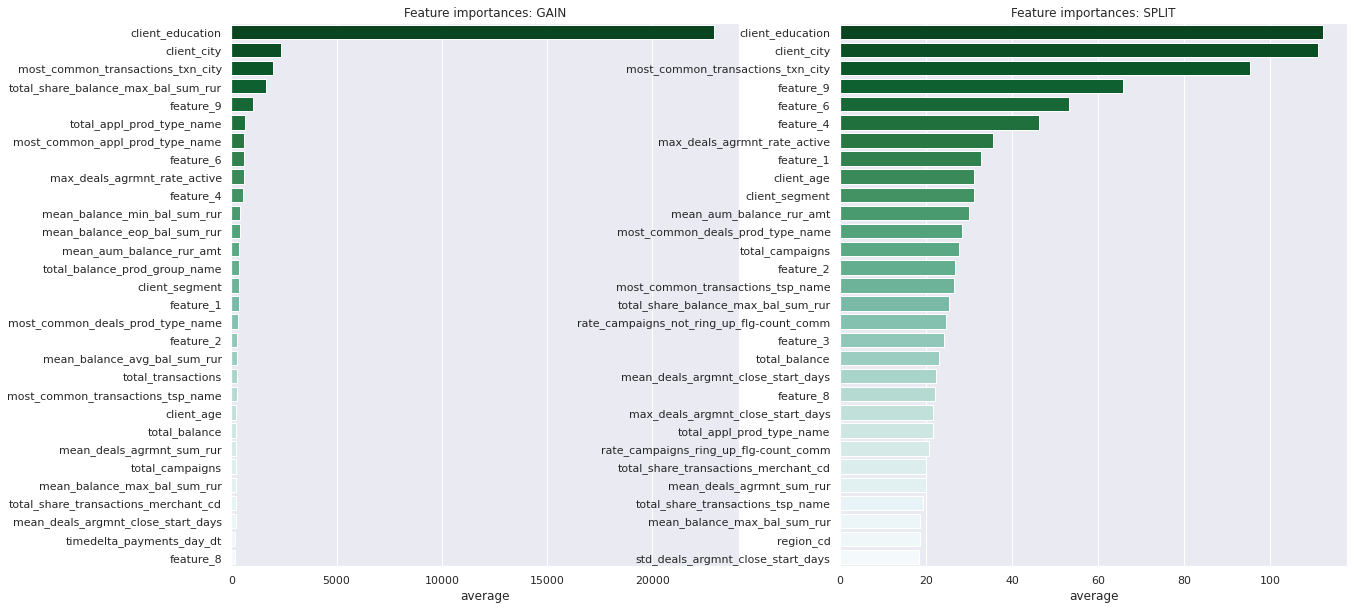

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.barplot(data=df_models_fe_gain.sort_values(by='average', ascending=False).head(30), x='average', y='feature', palette="BuGn_r", ax=ax[0])
ax[0].set_title('Feature importances: GAIN')
ax[0].set_ylabel('')
sns.barplot(data=df_models_fe_split.sort_values(by='average', ascending=False).head(30), x='average', y='feature', palette="BuGn_r", ax=ax[1])
ax[1].set_title('Feature importances: SPLIT')
ax[1].set_ylabel('')
plt.show()

In [86]:
retrain_after_valid = False
if retrain_after_valid:
    running_train(X, Y, None, None, i_fold=-1, seed=4444)

In [87]:
if USE_WANDB:
    wandb.run.summary["validation_f1"] = validation_f1
    wandb.run.summary["anic"] = 1/3*public_score+ 2/3 * private_score

In [23]:
if make_submission:
    public_anic = float(input())
    wandb.run.summary["public_anic"] = public_anic

 5798.90


In [24]:
if USE_WANDB:
    run.finish()

validation_f1,0.66799
anic,5689.74474
public_anic,5798.9
